## Fast Simulation of SNNs

### Computing the firing times
SNNs are known to produce very sparse spiking activity. However, simulating a SNNs requires solving the Euler integration corresponding to the differential equation of Synapse and Membrane potential. A method currently applied is to quantize the time and solve this differential equation via quantization. However, this may take a lot of time and may suffer in terms of accuracy.

Our goal here is to propose a simple method that uses the impulse responses of corresponding differential equations to obtain the firing times exactly. Note that extractiung the firing times of the neurons is enough for training and evaluation of SNNs. For example, it has been shown that the gradient of the loss with respect to the weights depends on the gradient of the firing times with respect to the weights, which implies that just knowing the firing time and their gradient is enough for gradient-based training.

### Some assumptions and insights
We assume that the synapse and membrane are first-orde systems with time-constants $\tau_s=\frac{1}{\alpha}$ and $\tau_m=\frac{1}{\beta}$. The corresponding impulse responses are $h_s(t)=e^{-\alpha t} u(t)$ and $h_m(t)=e^{-\alpha t} u(t)$, respectively. Also, the combination of the two impulse responses is given by 
$$h(t)=h_s(t) \star h_m(t) = \frac{ e^{-\beta t} - e^{-\alpha t} }{\alpha - \beta}  u(t).$$

These impulse responses are illustrated below for $\alpha=1, \beta=2$.

Text(0.5, 1.0, 'Total Kernel')

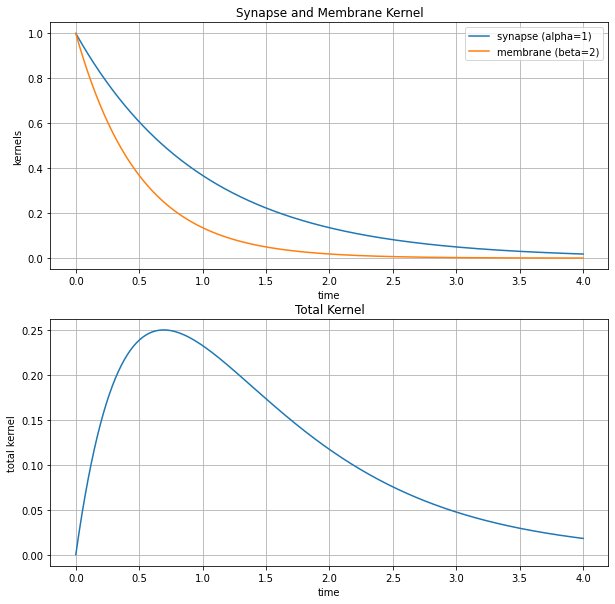

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

# parameters
alpha=1
beta=2

# time
t=np.linspace(0,4,500)

# impulse responses
hs=np.exp(-alpha*t)
hm=np.exp(-beta*t)
h=(np.exp(-alpha*t) - np.exp(-beta*t))/(beta-alpha)

# plot the results
plt.figure(figsize=(10,10))

plt.subplot(211)
plt.plot(t,hs)
plt.plot(t,hm)
plt.grid(True)
plt.xlabel('time')
plt.ylabel('kernels')
plt.title('Synapse and Membrane Kernel')
plt.legend([f'synapse (alpha={alpha})', f'membrane (beta={beta})'])

plt.subplot(212)
plt.plot(t,h)
plt.grid(True)
plt.xlabel('time')
plt.ylabel('total kernel')
plt.title('Total Kernel')




### Nice Feature of Exponential Kernel
Exponential kernels have the nice feature that the shifted version of an exponential kernel is just a scaling of the kernel. To be more specific, suppose we have two spikes into the system at time $t_1$ and $t_2>t_1$ with weights $w_1$ and $w_2$. Then, for example, the total kernel value for all times $t > t_2$ can be written as 
$$w_1 h(t-t_1) + w_2 h(t-t_2) = \frac{w_1 e^{\beta t_1} + w_2 e^{\beta t_2}}{\alpha-\beta} e^{-\beta t} + \frac{w_1 e^{\alpha t_1} + w_2 e^{\alpha t_2}}{\beta-\alpha} e^{-\alpha t}.$$
So, it is seen that due to the special structure of the exponential kernel, the resulting membrane potential is always of the form $A e^{-\alpha t} + B e^{-\beta t}$ for some suitable $A$ and $B$. 

A problematic part is when the membrane potential reaches the firing threshold $\theta$ where it is reduced by $\theta$ immediately. One can show that such a reset can be modelled by adding the term $-\theta e^{-\beta (t-t_f)} u(t-t_f)$ to the membrane potential where $t_f$ is the firing time. It is seen that even this nonlinear reset can be modelled in terms of sum of two exponentials of the form $A e^{-\alpha t} + B e^{-\beta t}$ for all times $t\geq t_f$.

So, from this simple explanation, it is seen that, in terms of simulation of SNNs and computing their firing times, we need to just find a simple method to compute the first intersection of the curve $A e^{-\alpha t} + B e^{-\beta t}$ with the horizontal line $\theta$. If such a method is available, we can compute the next firing time and also compute all firing times quite fast.

In the following, we develop such methods.

Solution was found at t_f=0.08567681048310934, val_f=0.20000000159419085


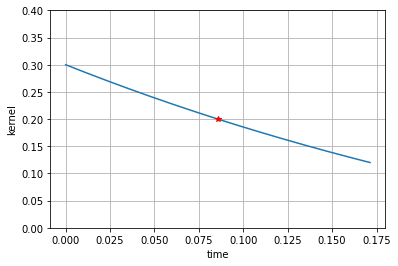

In [140]:
def solve(A,alpha, B, beta, theta):
    """
    A, alpha: weights corresponding to the synapse
    B, beta: weights corresponding to the membrane
    theta: the firing threshold
    
    aim: solve
        A exp(-alpha t) + B exp(-beta t) = theta
    """
    
    #============= find the value and the derivative of function at t=0 =======
    # value of the function at t=0
    val_0= A+B
    
    # derivative of the functionat t=0
    der_0=-alpha*A-beta*B
    
    
    #=========== find the extremum point in [0, infty]==========
    
    #----------- compute the extremum point parameter --------
    # if this parameter is negative the function is monotone
    par_ext=-(beta*B)/(alpha*A)
    
    # compute the extremeum point 
    if par_ext<0:
        t_ext=0
    else:
        if alpha!=beta:
            t_ext= np.maximum(np.log(par_ext)/(beta-alpha), 0.)
        else:
            # use l'Hopital rule
            t_ext=np.log(-B/A)*(1/alpha)
    
    # the extremum value
    val_ext=A*np.exp(-alpha*t_ext) + B*np.exp(-beta*t_ext)
    
    
    #================ decide based on the info ========
    if val_0>theta and val_ext>theta:
        # the function is increasing at first and starts above theta
        t_min=t_ext
        t_max=np.inf
    elif val_0>theta and val_ext<theta:
        # the function has a minimum
        t_min=0
        t_max=t_ext
    elif val_0<theta and val_ext>theta:
        # the function is increasing at first and has a maximum
        t_min=0
        t_max=t_ext
    elif val_0<theta and val_ext<theta:
        # the function starts below theta and is decreasing at first
        # it cannot intersect theta
        return None
    else:
        print("val_0=", val_0)
        print("val_ext=", val_ext)
        return None
    
    #================= refine the search interval ==================
    
    #------------ first: solve the problem of t_max in case it is None -------
    if t_max==np.inf:
        ab=alpha if alpha<beta else beta
        t_max=1/ab
        scale=2
        while True:
            # evaluate the function
            val_max=A*np.exp(-alpha*t_max) + B*np.exp(-beta*t_max)
            if val_max < theta:
                break
                
            # if not yet below the threshold theta: scale t_max
            t_max=scale*t_max
    
    #------------ Now t_min and t_max are known:=> refine the interval --------
    val_min=A*np.exp(-alpha*t_min)+B*np.exp(-beta*t_min)
    val_max=A*np.exp(-alpha*t_max)+B*np.exp(-beta*t_max)

    while True:
        # find the point in the middle
        t_mid=(t_min + t_max)/2
        val_mid=A*np.exp(-alpha*t_mid)+B*np.exp(-beta*t_mid)
        
        # check the condition
        if (val_mid>theta and val_max>theta) or (val_mid<theta and val_max<theta):
            t_max=t_mid
        else:
            t_min=t_mid
        
        # compute the precision
        rel_err=0.0000001
        dt=t_max-t_min
        t_avg=(t_max+t_min)/2
        if dt/t_avg < rel_err:
            break
        
    return t_avg

def plot_kernel(A,alpha,B,beta,theta,t_f):
    if t_f==None:
        t_plot=2/min([alpha,beta])
    else:
        t_plot=2*t_f
        
    t=np.linspace(0,t_plot,1000)
    
    kernel=A*np.exp(-alpha*t)+B*np.exp(-beta*t)
    
    
    plt.figure()
    plt.plot(t,kernel)
    plt.grid(True)
    plt.xlabel('time')
    plt.ylabel('kernel')

    if t_f!=None:
        kernel_f=A*np.exp(-alpha*t_f)+B*np.exp(-beta*t_f)
        plt.plot(t_f,kernel_f,'r*')
        plt.ylim([0,2*theta])
        
    plt.show()


# test solve
A=-0.7
B=1
alpha=1
beta=2
theta=0.2
t_f=solve(A,alpha,B,beta, theta)

if t_f==None:
    print("No solution was found")
    plot_kernel(A,alpha,B,beta,theta,t_f)
else:
    val_f=A*np.exp(-alpha*t_f)+B*np.exp(-beta*t_f)
    print(f"Solution was found at t_f={t_f}, val_f={val_f}")
    plot_kernel(A,alpha,B,beta,theta,t_f)

### Procesing the input spikes
Now we have a robust method to find the next firing time for a given value of $\alpha, \beta$ and exponential weights $A$ and $B$. So, the next step is to design an algorithm that takes a collection of input firing from previous neurons, the weight vector connecting those neurons to the target neuron, and compute the firing times of the target neuron.

In [141]:
# function for estimating the firing time
def evolve(spikes, w, A=0, B=0, alpha=2,beta=1, theta=1):
    # check the validity of alpha and beta
    if alpha==beta:
        raise ValueError('There might be some numerical instability for equal alpha and beta.')
        
    # number of neurons
    N=len(spikes)
    
    # produce the corresponding weights
    w_mat=[]
    for i, el in enumerate(w):
        leni=len(spikes[i])
        w_mat.append([w[i]]*leni)
    
    # unpack the spikes and weights
    #spk=np.array([sp for spk_neuron in spikes for sp in spk_neuron ])
    #wt=np.array([wi for w_neuron in w_mat for wi in w_neuron])
    
    spk=np.concatenate(spikes)
    wt=np.concatenate(w_mat)
    
    #print(spk.shape)
    #print(wt.shape)
    #print(w_mat)
    
    # sort the firing time and keep the same order for weights
    order=np.argsort(spk)
    
    spk=spk[order]
    wt=wt[order]
    
    #print("spk=", spk)
    #print("wt=", wt)
    
    
    # reference time and next firing time
    start=0
    
    fire_max=np.max(spk)+1
    fire=fire_max
    
    # list to save firing time
    fire_time=[]
    
    # define the iterator
    spk_iter=iter(zip(spk,wt))
    
    while (fw:=next(spk_iter,None)) is not None:
        # read the weight and firing time of the next spike
        f,w=fw
        
        # check to see if the firing time "f" is larger than the next predicted 
        # firing time
        if f>fire:
            # fire is valid firing time because it happens before "f"
            
            # (1) save this firing time as valid one
            fire_time.append(fire)
            
            # (2) update the potentials due to firing
            A=A*np.exp(-alpha*(fire-start))
            B=B*np.exp(-beta*(fire-start))-theta # the effect of membrane reset
            
            # (3) change the start to the latest firing time
            start=fire
            
            #print("potential at the firing time=", A, B, A+B)
            
            # (4) tricky part:
            # it may happen that even after potential reset, the neuron has several
            # new firings even before it receives a new spike from its neigboring neurons
            # we should add all these firing time
            while True:
                # a simple sufficient condition
                # if the derivative is negative no new firing can happen
                if -(A*alpha+B*beta)<0:
                    fire=fire_max+1
                    break
                
                # otherwise find the next root starting from the reference
                fire_rel=solve(A,alpha,B,beta,theta)
                
                # take into account the effect of reference point
                
                if fire_rel==None or fire_rel+start>f:
                    fire=fire_max+1
                    break
                
                # otherwise the firing time is a valid one
                # (1) save the firing time
                # take the reference into account
                fire=fire_rel+start
                
                fire_time.append(fire)
                
                # (2) update the potentials due to firing
                A=A*np.exp(-alpha*(fire_rel))
                B=B*np.exp(-beta*(fire_rel))-theta # the effect of membrane reset
                
                #print("potential at the firing time=", A, B, A+B)
                
                # (3) change the start to the latest firing time
                start=fire
                
                # (4) continue this procedure to register all in-between firing times
        
        # now there are no residula firing times from past
        # the new input spike should be processed
        
        # update A and B until the current firing time "f"
        A=A*np.exp(-alpha*(f-start))
        B=B*np.exp(-beta*(f-start))
        
        # add the effect of new spike
        A+=w/(beta-alpha)
        B+=w/(alpha-beta)
        
        #print("A and B at the start of pulse: ", A,B)
        
        # also adjust the reference time
        start=f
        
        # find the firing time for the updated kernel
        fire_rel=solve(A,alpha, B, beta, theta)
        
        # if there is no firing time: set fire to infinity (here fire_max+1)
        if fire_rel==None:
            fire=fire_max+1
            #print("No firing time in this interval")
        else:
            # adjust the firing time with respect to the reference point
            fire=fire_rel+start
            #print("speculated firing time: ", fire)
        
    # at this stage all input spikes are processed but the neuron
    # may keep producing spikes due to its residual potential
    # we need to add also those firing times
    while fire<fire_max:
        # still some residual firing left
        
        # add fire to the list
        fire_time.append(fire)
        
        # adjust the parameters
        A=A*np.exp(-alpha*(fire-start))
        B=B*np.exp(-beta*(fire-start))
        
        # adjust the reference time
        start=fire
        
        # a simple sufficient condition
        # if the derivative is negative no new firing can happen
        if -(A*alpha+B*beta)<0:
            fire=fire_max+1
            break

        # otherwise find the next root starting from the reference
        fire_rel=solve(A,alpha,B,beta,theta)

        # take into account the effect of reference point and decide
        if fire_rel==None or fire_rel+start>fire_max:
            fire=fire_max+1
            break
        else:
            # adjust the firing time with respect to the refernce
            # repeat the loop
            fire=fire_rel+start
        
    # return the produced spikes
    return fire_time
        


Text(0, 0.5, 'Membrane Potential')

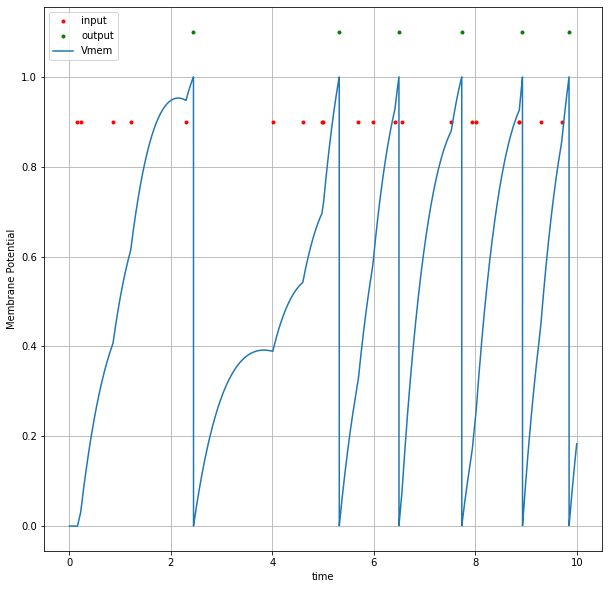

In [142]:
#================= test evolve: only one input neuron ================

# number of neurons on the previous layer
N=1

# number of firing times per neuron
F=20

# total simulation time
t_sim=10

# produce firing times for neurons
spikes=np.sort(t_sim*np.random.rand(N,F),axis=1)

# plot the spikes
#TSEvent(times=spikes.T, t_start=0, t_stop=t_sim).plot()

# produce the corresponding weights
# make sure we have both positive and negative weights
#w=np.random.randn(N)
w=[0.5]

        
#evolve(spikes, w, A=0, B=0, alpha=2,beta=1, theta=1):
A=0; alpha=1;
B=0; beta=0.5;

theta=1

# obtain the firing times
fire_time=evolve(spikes=spikes,w=w,A=A,B=B,alpha=alpha,beta=beta,theta=theta)

# plot the results for sanity check
t=np.linspace(0, t_sim, 10000)
v_pot=np.zeros_like(t)

# add the effect of input firing times
spikes=spikes.ravel()
for f in spikes:
    v_pot+=w*(np.exp(-alpha*(t-f))-np.exp(-beta*(t-f)))/(beta-alpha)*np.heaviside(t-f,0)

# add the effect of potential reset
for f in fire_time:
    v_pot-=theta*np.exp(-beta*(t-f))*np.heaviside(t-f,0)

# plot the membrane potential
plt.figure(figsize=(10,10))
plt.plot(spikes,0.9*np.ones_like(spikes), 'r.')
plt.plot(fire_time,1.1*np.ones_like(fire_time), 'g.')
plt.plot(t,v_pot)
plt.grid(True)
plt.legend(['input', 'output', 'Vmem'])
plt.xlabel('time')
plt.ylabel('Membrane Potential')
    


In [ ]:
#================= test evolve: more than one input neuron ================

# number of neurons on the previous layer
N=81

# number of firing times per neuron
F=20

# total simulation time
t_sim=10

# produce firing times for neurons
spikes=np.sort(t_sim*np.random.rand(N,F),axis=1)

# plot the spikes
#TSEvent(times=spikes.T, t_start=0, t_stop=t_sim).plot()

# produce the corresponding weights
# make sure we have both positive and negative weights
w=np.random.randn(N)
#w=[0.5, -0.2]

        
#evolve(spikes, w, A=0, B=0, alpha=2,beta=1, theta=1):
A=0; alpha=1;
B=0; beta=0.5;

theta=1

# obtain the firing times
fire_time=evolve(spikes=spikes,w=w,A=A,B=B,alpha=alpha,beta=beta,theta=theta)

# plot the results for sanity check
t=np.linspace(0, t_sim, 10000)
v_pot=np.zeros_like(t)

# add the effect of input firing times
for i,spk in enumerate(spikes):
    for f in spk:
        v_pot+=w[i]*(np.exp(-alpha*(t-f))-np.exp(-beta*(t-f)))/(beta-alpha)*np.heaviside(t-f,0)

# add the effect of potential reset
for f in fire_time:
    v_pot-=theta*np.exp(-beta*(t-f))*np.heaviside(t-f,0)

# plot the membrane potential
plt.figure(figsize=(10,10))
for spk in spikes:
    plt.plot(spk,0.9*np.ones_like(spk), '.')
    
plt.plot(fire_time,1.1*np.ones_like(fire_time), '.')
plt.plot(t,v_pot)
plt.grid(True)
plt.legend([*([f'input-{i}' for i in range(1,N+1)]), 'output', 'Vmem'])
plt.xlabel('time')
plt.ylabel('Membrane Potential')
    



### Some Insight on the Input and Output Rate
Consider a specific neuron and suppose that it is fed with $N$ neurons at its input. We assume that the neuron has a membrane time constant of $\tau_m=\frac{1}{\beta}$. Let us consider a very general scenario where the $i$-th input neuorn has synaptic consatant of $\tau_{s,i}=\frac{1}{\alpha_i}$ and is connected with a weight $w_i$.

Consider a long simulation time and assume that during this time we received $S_i$ spikes from $i$-th input neuron. Note that we can write the membrane potential as 
$$ V(t)= \sum_{i=1}^N w_i\sum_{j=1}^{S_i} h_{sm,i}(t-f_{i,j}) - \theta \sum_{k=1}^{S_o} h_m(t-f_{o,k}),$$
where $f_{i,j}$ denotes the $j$-th firing time of $i$-th neuron, where $f_{o,k}$ denotes the $k$-th output firing time, where $h_{m}(t)$ is the exponential impulse response of the membrane, and $h_{sm,i}(t)=h_m(t)\star h_{s,i}(t)$ is the combined impulse responses of the membrane and the $i$-th input synapse. 

In a steady-state and stable scenario we expect that the membrane potential has a limited fluctuation range in some interval $[-\kappa \theta, \theta]$ where $\kappa>0$ is a fixed parameter and where the upper bound comes from the fact that the membrane potential is reset as soon as it exceeds the threshold $\theta$. If this stability condition holds, we may expect that the time average of the membrane potential given by 
$$\bar{V}=\frac{1}{T} \int_{0}^T V(t) dt,$$
is also in the range $[-\kappa \theta,\theta]$. Here, we denoted the sufficiently large simulation time by $T$ where sufficiently large means compared with the time constants of the membrane and synapses, i.e., 
$$T \gg \max\Big ( \frac{1}{\alpha_i}, \frac{1}{\beta} \Big).$$

Now we use the fact that for sufficiently large $T$, we have
$$\int_{0}^T h_m(t-f_{o,k}) \approx \int_{0}^\infty h_m(t) dt= \frac{1}{\beta}.$$
And, also that 
$$\int_{0}^T h_{sm,i}(t-f_{i,j}) \approx \int_{0}^\infty h_{sm,i}(t) dt= \int_{0}^\infty h_{s,i}(t)\star h_m(t) dt=\int_{0}^\infty h_{s,i}(t)dt \times \int_{0}^\infty h_{m}(t)dt =\frac{1}{\beta \alpha_i},$$
where we used the well-known result for the time integral of the convolution of two functions.

replacing this result in the time-average of the membrane potential yields
$$\sum_{i=1}^N w_i S_i/(\alpha_i \beta) - \theta S_o/\beta \approx \bar{V} T \in [-\kappa \theta, \theta] \times T.$$

Dividing both sides by $T$ and defining the spike rates by $r_i=\frac{S_i}{T}$ and $r_o=\frac{S_o}{T}$ we obtain that
$$ \sum_{i=1}^N w_i r_i/\alpha_i = (r_o + \zeta \beta)\theta,$$
where $\zeta$ is some number in the range $[-\kappa,1]$. It might be more insightful if one writes this expression in terms of time constants $\tau_i$ and $\tau$  where one obtains the identity
$$ \sum_{i=1}^N w_i r_i \tau_i = \frac{r_o \tau_m+ \zeta }{\tau_m } \theta .$$
Note that $r_o \tau_m$ is a unit-less parameters which measures the number of output spikes produced during the settling time or time constant of the membrane. In typical scenarios, we may expect to have $n_0=r_0 \tau_m$ larger than 1 (under-firing regimes) and perhaps less than 10 (over-firing regime). So, we may also expect that, in a good working regime of the network, $n_0+ \zeta \approx 1-10$. Similarly, we can also define the average number of input firings within the corresponding synamptic time constant as $n_i=r_i \tau_{i}$ and we can re-write the identity as
$$\sum_{i=1}^N w_i n_i = \frac{n_o + \zeta}{\tau_m } \theta.$$
One should also note that we may need to adjust the firing threshold based on the time constant of the membrane.

**Solving Vanishing Gradient Issue:**
This equation can be used as a design metric during the training to avoid under-firing issues in the network which creates the well-known vanishing gradient problem. More specifically, we set the parameter $\zeta$ (depending on the range of variation of the membrane potential), say for example $\zeta=0$ and decide on the target firing rate $n_i$ and $n_o$ we would like to have for the input and output neurons. Then, given these targeted design parameters, the equation above enforces an affine constraint on the input weights of each neuron. Therefore, during the training, we just use the gradient backpropagation and then project the resulting weights on these affine constraint set. In this way, we can completely avoid the vanishing gradient issue.

As a simple example, suppose we set all $n_i$ equal and equal to $n_0$ and set $\zeta=0$, and define $\frac{1}{\tau_m }\theta=\gamma$. Then, we obtain a simple affine constraint as follows:
$$\sum_{i=1}^N w_i = \gamma.$$

The projection on this affine set is indeed very simple:
$$ w_i \to w_i -\frac{\sum_{j=1}^N w_j -\gamma}{N}, \ \ i=1,2, \dots, N.$$


We investigate this relation via the following simulation.


In [ ]:
#================= test the identity under stability condition ================

# number of neurons on the previous layer
N=81

# number of firing times per neuron
num_f_max=1000
F=(np.random.rand(N)*num_f_max).astype(int)

# total simulation time
t_sim=10

# produce firing times for neurons
spikes=[]
for num_f in F:
    spikes.append(np.sort(t_sim*np.random.rand(num_f)))

# rate vector
r_in=[]
for spk in spikes:
    r_in.append(len(spk)/t_sim)
    
r_in=np.array(r_in)

# plot the spikes
#TSEvent(times=spikes.T, t_start=0, t_stop=t_sim).plot()

# produce the corresponding weights
# make sure we have both positive and negative weights
w=np.random.randn(N)
#w=[0.5, -0.2]

        
#evolve(spikes, w, A=0, B=0, alpha=2,beta=1, theta=1):
A=0; alpha=1;
B=0; beta=0.5;

theta=1

# obtain the firing times
fire_time=evolve(spikes=spikes,w=w,A=A,B=B,alpha=alpha,beta=beta,theta=theta)

# compute the output rate
r_out=len(fire_time)/t_sim

# right-hand-side
rhs=np.sum(w*r_in)/alpha

# lhs
lhs=r_out*theta

# compute zeta
zeta=(rhs-lhs)/(theta*beta)

# print
print(f"r_in={r_in}")
print(f"r_out={r_out}, zeta*beta={zeta*beta}")
print(f"lhs={lhs}, rhs={rhs}, zeta={zeta}")

r_in=[79.  33.9 44.4 78.  51.6 22.3 76.4  2.9 82.7 84.4 99.3 86.3 31.1 56.9
 13.5 43.5 58.4 20.3 56.  64.  10.  55.1 48.7  7.5 96.2 73.9 50.  26.6
 37.9 98.3 80.4 19.  58.  73.5 53.1 78.7 74.2  6.5 40.8 27.7 25.4 74.
 99.2 76.9 16.6 49.  74.9 36.5 57.1 70.7 55.8 77.1 93.9 78.8 36.2 62.4
 92.6 69.4 63.4 98.2 43.3 34.9  2.6 94.8 27.  93.4 19.6 48.  99.1 98.3
 28.9 52.3 50.7 93.9 35.5 94.6 27.8 68.8 49.7 33.  98.5]
r_out=593.7, zeta*beta=70.5977556200495
lhs=593.7, rhs=664.2977556200495, zeta=141.195511240099
